In [85]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
crop_train_291.h5	  pre15.png	   Train
crop_train.h5		  pre20.png	   VDSR_ADAM_291.h5
crop_train_no_overlap.h5  pre2.png	   VDSR_ADAM_91_10.h5
input10.png		  pre5.png	   VDSR_ADAM_91_15.h5
input15.png		  prepare_data.py  VDSR_ADAM_91_20.h5
input20.png		  __pycache__	   VDSR_ADAM_91_5.h5
input2.png		  t1.png	   VDSR_check.h5
input5.png		  Test
pre10.png		  test.h5


In [86]:
import os 
os.chdir("/content/drive/My Drive/Image_super_resolution/VDSR_implementation")
os.getcwd()
!ls

crop_train_291.h5	  pre15.png	   Train
crop_train.h5		  pre20.png	   VDSR_ADAM_291.h5
crop_train_no_overlap.h5  pre2.png	   VDSR_ADAM_91_10.h5
input10.png		  pre5.png	   VDSR_ADAM_91_15.h5
input15.png		  prepare_data.py  VDSR_ADAM_91_20.h5
input20.png		  __pycache__	   VDSR_ADAM_91_5.h5
input2.png		  t1.png	   VDSR_check.h5
input5.png		  Test
pre10.png		  test.h5


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization, Activation,add
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint,Callback, LearningRateScheduler
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import prepare_data as pd
import numpy 
import math
from keras.models import Model

In [39]:
IMG_SIZE = (41, 41, 1)
SIZE=10000
%matplotlib inline
data,label=pd.read_training_data("crop_train.h5")
print(data.shape,label.shape)
# print(data[0][0][0][0])
# data_img=data[5]
# label_img=label[5]
# data=data
# label=label
# fig,axes=plt.subplots(1,2)
# axes[0].imshow(data_img)
# axes[1].imshow(label_img)
data_Y, label_Y = pd.read_training_data("./test.h5")
print(data_Y.shape,label_Y.shape)

(13717, 41, 41, 1) (13717, 41, 41, 1)
(420, 41, 41, 1) (420, 41, 41, 1)


In [0]:
def psnr(target, ref):
    mse = numpy.mean( (target - ref) ** 2 )
    PIXEL_MAX = 255.0
    if mse == 0:
        return 100
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

In [0]:
def model(num_layers):
    
    input_img = Input(shape=IMG_SIZE)
    VDSR = Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_uniform')(input_img)
    for i in range(num_layers-2):
        VDSR = Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_uniform')(VDSR)
        VDSR = Activation('relu')(VDSR)
    VDSR = Conv2D(1, (3, 3), padding='same', kernel_initializer='glorot_uniform')(VDSR)
    res_img = VDSR

    output_img = add([res_img, input_img])
    VDSR = Model(input_img, output_img)
    adam = Adam(clipvalue=0.5)
    VDSR.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return VDSR

def predict_model(num_layers):
    
    input_img = Input(shape=(None,None,1))
    VDSR = Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_uniform')(input_img)
    for i in range(num_layers-2):
        VDSR = Conv2D(64, (3, 3), padding='same', kernel_initializer='glorot_uniform')(VDSR)
        VDSR = Activation('relu')(VDSR)
    VDSR = Conv2D(1, (3, 3), padding='same', kernel_initializer='glorot_uniform')(VDSR)
    res_img = VDSR

    output_img = add([res_img, input_img])
    VDSR = Model(input_img, output_img)
    adam = Adam(clipvalue=0.5)
    VDSR.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    return VDSR


def step_decay(epoch):
   initial_lrate = 0.0003
   drop = 1
   epochs_drop = 20.0
   lrate = initial_lrate * math.pow(drop,math.floor(epoch/epochs_drop))
   return lrate

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.t_losses = []
       self.v_losses=[]
       self.lr = []
 
    def on_epoch_end(self, epoch, logs={}):
       self.v_losses.append(logs.get('val_loss'))
       self.t_losses.append(logs.get('loss'))
       self.lr.append(step_decay(epoch))
    
class PsnrHistory_Y(Callback):
    def __init__(self,num_layers):
        self.num_layers=num_layers

    def on_train_begin(self, logs={}):
        self.psnrs = []
        
    def on_epoch_end(self, epoch, logs={}):
        VDSR = predict_model(self.num_layers)
        VDSR.load_weights("VDSR_ADAM_91"+"_"+str(self.num_layers)+".h5")
        avg_psnr=0.0
        import cv2
        for i in range(0,data_Y.shape[0]):
            img=data_Y[i]
            Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
            Y[0, :, :, :] = img
            pre = VDSR.predict(Y, batch_size=1) * 255.
            pre[pre[:] > 255] = 255
            pre[pre[:] < 0] = 0
            img_pre=pre[0,:,:,:]
            avg_psnr=avg_psnr+psnr(label_Y[i]*255, img_pre)

        avg_psnr=(avg_psnr/data_Y.shape[0])        
        self.psnrs.append((avg_psnr))

def train(num_layers,history):
    VDSR = model(num_layers)
    print(VDSR.summary())
    data, label = pd.read_training_data("./crop_train.h5")
    val_data, val_label = pd.read_training_data("./test.h5")
    # data =data[0:SIZE]
    # label=label[0:SIZE]
    print(data.shape,label.shape)
    print(val_data.shape,val_label.shape)
    loss_history = LossHistory()
    lrate = LearningRateScheduler(step_decay,verbose=1)
    checkpoint = ModelCheckpoint("VDSR_ADAM_91"+"_"+str(num_layers)+".h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint,loss_history, lrate,history]
    VDSR.fit(data, label, batch_size=64, validation_data=(val_data, val_label),
                    callbacks=callbacks_list, shuffle=True, nb_epoch=40, verbose=0)
    print(loss_history.lr)
    print(loss_history.t_losses)
    print(loss_history.v_losses)
    # srcnn_model.load_weights("m_model_adam.h5")

In [65]:
history_Y_5=PsnrHistory_Y(5)
train(5,history_Y_5)
print(history_Y_5.psnrs)

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           (None, 41, 41, 1)    0                                            
__________________________________________________________________________________________________
conv2d_162 (Conv2D)             (None, 41, 41, 64)   640         input_25[0][0]                   
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 41, 41, 64)   36928       conv2d_162[0][0]                 
__________________________________________________________________________________________________
activation_127 (Activation)     (None, 41, 41, 64)   0           conv2d_163[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 00001: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00001: val_loss improved from inf to 0.00154, saving model to VDSR_ADAM_91_5.h5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00002: val_loss improved from 0.00154 to 0.00147, saving model to VDSR_ADAM_91_5.h5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00003: val_loss improved from 0.00147 to 0.00144, saving model to VDSR_ADAM_91_5.h5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00004: val_loss improved from 0.00144 to 0.00141, saving model to VDSR_ADAM_91_5.h5

Epoch 00005: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00005: val_loss improved from 0.00141 to 0.00140, saving model to VDSR_ADAM_91_5.h5

Epoch 00006: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00006: val_loss improved from 0.00140 to 0.00139, saving model to VDSR_ADAM_91_5.h5

Epoch 00007: LearningRateScheduler setting 

In [66]:
history_Y_10=PsnrHistory_Y(10)
train(10,history_Y_10)
print(history_Y_10.psnrs)

Model: "model_66"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_66 (InputLayer)           (None, 41, 41, 1)    0                                            
__________________________________________________________________________________________________
conv2d_367 (Conv2D)             (None, 41, 41, 64)   640         input_66[0][0]                   
__________________________________________________________________________________________________
conv2d_368 (Conv2D)             (None, 41, 41, 64)   36928       conv2d_367[0][0]                 
__________________________________________________________________________________________________
activation_250 (Activation)     (None, 41, 41, 64)   0           conv2d_368[0][0]                 
___________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 00001: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00001: val_loss improved from inf to 0.00151, saving model to VDSR_ADAM_91_10.h5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00002: val_loss improved from 0.00151 to 0.00142, saving model to VDSR_ADAM_91_10.h5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00003: val_loss improved from 0.00142 to 0.00137, saving model to VDSR_ADAM_91_10.h5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00004: val_loss improved from 0.00137 to 0.00135, saving model to VDSR_ADAM_91_10.h5

Epoch 00005: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00005: val_loss did not improve from 0.00135

Epoch 00006: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00006: val_loss improved from 0.00135 to 0.00134, saving model to VDSR_ADAM_91_10.h5

Epoch 00007: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00

In [67]:
history_Y_20=PsnrHistory_Y(20)
train(20,history_Y_20)
print(history_Y_20.psnrs)

Model: "model_107"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_107 (InputLayer)          (None, 41, 41, 1)    0                                            
__________________________________________________________________________________________________
conv2d_777 (Conv2D)             (None, 41, 41, 64)   640         input_107[0][0]                  
__________________________________________________________________________________________________
conv2d_778 (Conv2D)             (None, 41, 41, 64)   36928       conv2d_777[0][0]                 
__________________________________________________________________________________________________
activation_578 (Activation)     (None, 41, 41, 64)   0           conv2d_778[0][0]                 
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 00001: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00001: val_loss improved from inf to 0.00149, saving model to VDSR_ADAM_91_20.h5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00002: val_loss improved from 0.00149 to 0.00143, saving model to VDSR_ADAM_91_20.h5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00003: val_loss improved from 0.00143 to 0.00140, saving model to VDSR_ADAM_91_20.h5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00004: val_loss improved from 0.00140 to 0.00137, saving model to VDSR_ADAM_91_20.h5

Epoch 00005: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00005: val_loss improved from 0.00137 to 0.00134, saving model to VDSR_ADAM_91_20.h5

Epoch 00006: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00006: val_loss improved from 0.00134 to 0.00133, saving model to VDSR_ADAM_91_20.h5

Epoch 00007: LearningRateScheduler se

In [68]:
history_Y_15=PsnrHistory_Y(15)
train(15,history_Y_15)
print(history_Y_15.psnrs)

Model: "model_148"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_148 (InputLayer)          (None, 41, 41, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1597 (Conv2D)            (None, 41, 41, 64)   640         input_148[0][0]                  
__________________________________________________________________________________________________
conv2d_1598 (Conv2D)            (None, 41, 41, 64)   36928       conv2d_1597[0][0]                
__________________________________________________________________________________________________
activation_1316 (Activation)    (None, 41, 41, 64)   0           conv2d_1598[0][0]                
__________________________________________________________________________________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.



Epoch 00001: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00001: val_loss improved from inf to 0.00146, saving model to VDSR_ADAM_91_15.h5

Epoch 00002: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00002: val_loss improved from 0.00146 to 0.00140, saving model to VDSR_ADAM_91_15.h5

Epoch 00003: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00003: val_loss improved from 0.00140 to 0.00136, saving model to VDSR_ADAM_91_15.h5

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00004: val_loss did not improve from 0.00136

Epoch 00005: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00005: val_loss improved from 0.00136 to 0.00133, saving model to VDSR_ADAM_91_15.h5

Epoch 00006: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00006: val_loss improved from 0.00133 to 0.00132, saving model to VDSR_ADAM_91_15.h5

Epoch 00007: LearningRateScheduler setting learning rate to 0.0003.

Epoch 00

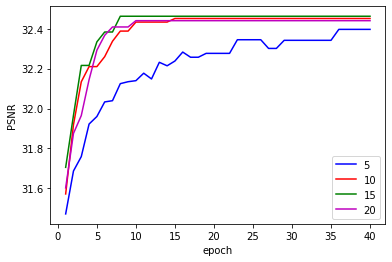

In [76]:
x1=numpy.linspace(1,len(history_Y_5.psnrs),len(history_Y_5.psnrs))
y1 = numpy.asarray(history_Y_5.psnrs, dtype=numpy.float32)
x2=numpy.linspace(1,len(history_Y_10.psnrs),len(history_Y_10.psnrs))
y2 = numpy.asarray(history_Y_10.psnrs, dtype=numpy.float32)
x3=numpy.linspace(1,len(history_Y_15.psnrs),len(history_Y_15.psnrs))
y3 = numpy.asarray(history_Y_15.psnrs, dtype=numpy.float32)
x4=numpy.linspace(1,len(history_Y_20.psnrs),len(history_Y_20.psnrs))
y4 = numpy.asarray(history_Y_20.psnrs, dtype=numpy.float32)
fig, ax = plt.subplots()
ax.plot(x1,y1, '-b', label='5')
ax.plot(x2,y2, '-r', label='10')
ax.plot(x3,y3,'-g',label="15")
ax.plot(x4,y4,'-m',label="20")
leg = ax.legend();
plt.ylabel('PSNR')
plt.xlabel('epoch')
plt.show(fig)

In [0]:
def predict(num_layers):
    VDSR = predict_model(num_layers)
    VDSR.load_weights("VDSR_ADAM_91"+"_"+str(num_layers)+".h5")
    IMG_NAME = "t1.png"
    INPUT_NAME = "input"+str(num_layers)+".png"
    OUTPUT_NAME = "pre"+str(num_layers)+".png"

    import cv2
    img = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    shape = img.shape
    Y_img = cv2.resize(img[:, :, 0], (int(shape[1] / 2), int(shape[0] / 2)), cv2.INTER_CUBIC)
    Y_img = cv2.resize(Y_img, (shape[1], shape[0]), cv2.INTER_CUBIC)
    print(img.shape,Y_img.shape)
    img[:, :, 0] = Y_img
    Y_img=img[:,:,0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    cv2.imwrite(INPUT_NAME, img)

    Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    Y[0, :, :, 0] = Y_img.astype(float) / 255.
    pre = VDSR.predict(Y, batch_size=1) * 255.
    print(pre.shape)
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(numpy.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    img[:,:,0] = pre[0,:,:,0]
    img = cv2.cvtColor(img, cv2.COLOR_YCrCb2BGR)
    print(img.shape)
    cv2.imwrite(OUTPUT_NAME, img)

    # psnr calculation:
    im1_rgb = cv2.imread(IMG_NAME, cv2.IMREAD_COLOR)
    im1_Y = cv2.cvtColor(im1_rgb, cv2.COLOR_BGR2YCrCb)
    im2_rgb = cv2.imread(INPUT_NAME, cv2.IMREAD_COLOR)
    im2_Y = cv2.cvtColor(im2_rgb, cv2.COLOR_BGR2YCrCb)
    im3_rgb = cv2.imread(OUTPUT_NAME, cv2.IMREAD_COLOR)
    im3_Y = cv2.cvtColor(im3_rgb, cv2.COLOR_BGR2YCrCb)
    print(im3_Y.shape,im1_Y.shape)
    print("bicubic:")
    print("YCrCCb= {} , RGB={}".format(psnr(im1_Y[:,:,0],im2_Y[:,:,0]),psnr(im1_rgb,im2_rgb)))
    print("VDSR:")
    print("YCrCCb= {} , RGB={}".format(psnr(im1_Y[:,:,0],im3_Y[:,:,0]),psnr(im1_rgb,im3_rgb)))

    # srcnn_model = predict_model()
    # srcnn_model.load_weights("SRCNN_check.h5")
    # avg_psnr=0.0
    # for i in range(0,data_Y.shape[0]):
    #     img=data_Y[i]
    #     Y = numpy.zeros((1, img.shape[0], img.shape[1], 1), dtype=float)
    #     Y[0, :, :, :] = img
    #     pre = srcnn_model.predict(Y, batch_size=1) * 255.
    #     pre[pre[:] > 255] = 255
    #     pre[pre[:] < 0] = 0
    #     img_pre=pre[0,:,:,:]
    #     avg_psnr=avg_psnr+psnr(label_Y[i]*255, img_pre)

    # avg_psnr=(avg_psnr/data_rgb.shape[0])
    # print(avg_psnr)

In [89]:
print("5")
predict(5)
print("10")
predict(10)
print("15")
predict(15)
print("20")
predict(20)

5
(481, 321, 3) (481, 321)
(1, 481, 321, 1)
(481, 321, 3)
(481, 321, 3) (481, 321, 3)
bicubic:
YCrCCb= 30.656837442172275 , RGB=30.656730765830783
VDSR:
YCrCCb= 31.199425229183937 , RGB=31.203097277947474
10
(481, 321, 3) (481, 321)
(1, 481, 321, 1)
(481, 321, 3)
(481, 321, 3) (481, 321, 3)
bicubic:
YCrCCb= 30.656837442172275 , RGB=30.656730765830783
VDSR:
YCrCCb= 31.24663870396399 , RGB=31.24625580463001
15
(481, 321, 3) (481, 321)
(1, 481, 321, 1)
(481, 321, 3)
(481, 321, 3) (481, 321, 3)
bicubic:
YCrCCb= 30.656837442172275 , RGB=30.656730765830783
VDSR:
YCrCCb= 31.224088959891443 , RGB=31.229739543119734
20
(481, 321, 3) (481, 321)
(1, 481, 321, 1)
(481, 321, 3)
(481, 321, 3) (481, 321, 3)
bicubic:
YCrCCb= 30.656837442172275 , RGB=30.656730765830783
VDSR:
YCrCCb= 31.22090542637387 , RGB=31.222964272789735
